In [196]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

gpu_idx = 4
device = torch.device(f"cuda:{gpu_idx}")
print(device)

In [197]:
neg_rng, pos_rng = -0.3, 0.3
t_min, t_max = -0.6, 0.6
neg_obs, pos_obs = -0.9, 0.9
a_min, a_max = 0.5, 10
n_samples = 11
n_disp = 220
snr_dB = 40
t_rng = torch.linspace(neg_obs, pos_obs, n_samples).to(device)
t_rng_disp = torch.linspace(neg_obs, pos_obs, n_disp).to(device)
scale = 5

In [198]:
def add_noise(signals, snr_dB):

    signal_power = torch.mean(signals ** 2, dim=1, keepdim=True)
    snr_linear = 10 ** (snr_dB / 10)
    noise_power = signal_power / snr_linear
    noise = torch.sqrt(noise_power) * torch.randn_like(signals)
    return signals + noise

def mse_db(pred, actual):
    mse = np.mean((pred - actual)**2)
    signal_power = np.mean(actual**2)

    return 10 * np.log10(mse / signal_power)

def get_batch(data, model, batch_size, idx, t_rng, p_idx):

    amp_batch = data["amps"][idx * batch_size : (idx + 1) * batch_size]
    loc_batch = data["locs"][idx * batch_size : (idx + 1) * batch_size] 

    return model.get_signal(amp_batch, loc_batch, t_rng, p_idx), loc_batch

In [199]:
class FRIModel(nn.Module):
    def __init__(self, n_inp, n_out, neg_rng, pos_rng, scale):
        super(FRIModel, self).__init__()

        self.n_inp = n_inp
        self.n_brd = scale * n_inp
        self.neg_rng = neg_rng
        self.pos_rng = pos_rng

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * n_inp, 128)
        self.fc2 = nn.Linear(128, n_out)
        self.brd_pts = torch.linspace(neg_rng, pos_rng, scale * n_inp).to(device)

        ## Gaussian
        self.g1 = torch.exp(-(self.brd_pts**2)/ (2 * (0.18 ** 2)))
        self.g2 = torch.exp(-(self.brd_pts**2)/ (2 * (0.09 ** 2)))

        ## Gaussian pair
        # self.gp = 1.4*(torch.exp(-(self.brd_pts + 0.2)**2 / (2 * (0.045 ** 2))) + torch.exp(-(self.brd_pts - 0.19)**2 / (2 * (0.045 ** 2))))
        # self.gp = 1.25 * torch.exp(-(self.brd_pts + 0.1)**2 / (2 * (0.06 ** 2))) + 0.7 * torch.exp(-(self.brd_pts - 0.16)**2 / (2 * (0.07 ** 2)))

        ## learnable kernel
        self.coeffs = nn.Parameter(torch.exp(-(self.brd_pts**2)/(2 * (self.pos_rng ** 2))))

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.gelu(self.conv1(x))
        x = F.gelu(self.conv2(x))
        x = F.gelu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.gelu(self.fc1(x))
        x = self.fc2(x)
        return x

    def get_ker(self, idx=0):
        if(idx == 0):
            return self.coeffs
        elif(idx == 1):
            return self.g1
        elif(idx == 2):
            return self.g2
        elif(idx == 3):
            return self.gp

    def get_brd_pts(self):
        return self.brd_pts


    def fn_val(self, c1, c2, strt, t_val, sep):

        ret_val = (c1 + ((c2 - c1) * (t_val - strt)) / sep).sum(dim=1)
        return ret_val


    def get_spikes(self, aks, tks, idx=0):
        ker = self.get_ker(idx).unsqueeze(0).unsqueeze(1)
        a = aks.unsqueeze(2) * ker
        t = tks.unsqueeze(2) + self.brd_pts

        return a, t

    def get_sig(self, t_samps, a, t):

        diffs = torch.abs(t.unsqueeze(-1) - t_samps.unsqueeze(0).unsqueeze(0).unsqueeze(0).expand(t.shape[0], t.shape[1], t.shape[2], -1))
        min_ids = torch.argmin(diffs, dim=-2)

        t_fs = torch.gather(t, 2, min_ids)
        t_samps_exp = t_samps.unsqueeze(0).unsqueeze(0).expand(t_fs.shape[0], t_fs.shape[1], -1)

        cond_1 = (t_fs < t_samps_exp) & (diffs[:, :, self.n_brd // 2, :] < self.pos_rng)
        cond_2 = (t_fs >= t_samps_exp) & (diffs[:, :, self.n_brd // 2, :] < self.pos_rng)
        cond_3 = (min_ids == 0) & (diffs[:,:,self.n_brd // 2, :] > self.pos_rng)
        cond_4 = (min_ids == self.n_brd - 1) & (diffs[:,:,self.n_brd // 2, :] > self.pos_rng)
        cond_5 = (min_ids == 0) & (diffs[:,:,self.n_brd // 2, :] < self.pos_rng)
        cond_6 = (min_ids == self.n_brd - 1) & (diffs[:,:,self.n_brd // 2, :] < self.pos_rng)

        min_ids[cond_3] = 1
        min_ids[cond_5] = 1
        min_ids[cond_4] = self.n_brd - 2
        min_ids[cond_6] = self.n_brd - 2

        strt_pts = torch.where(cond_3 | cond_4, -100, torch.where(cond_1, torch.where(cond_5, torch.gather(t, 2, min_ids - 1), torch.gather(t, 2, min_ids)), torch.where(cond_6, torch.gather(t, 2, min_ids), torch.gather(t, 2, min_ids - 1))))
        c1_vals = torch.where(cond_3 | cond_4, 0, torch.where(cond_1, torch.where(cond_5, torch.gather(a, 2, min_ids - 1), torch.gather(a, 2, min_ids)), torch.where(cond_6, torch.gather(a, 2, min_ids), torch.gather(a, 2, min_ids - 1))))
        c2_vals = torch.where(cond_3 | cond_4, 0, torch.where(cond_2, torch.where(cond_6, torch.gather(a, 2, min_ids + 1), torch.gather(a, 2, min_ids)), torch.where(cond_5, torch.gather(a, 2, min_ids), torch.gather(a, 2, min_ids + 1))))

        return self.fn_val(c1_vals, c2_vals, strt_pts, t_samps, self.brd_pts[1] - self.brd_pts[0])

    def get_signal(self, aks, tks, t_rng, idx=0):
        a_, t_ = self.get_spikes(aks, tks, idx)
        sig = self.get_sig(t_rng, a_, t_)
        return sig

In [200]:
tks_plot = torch.tensor([[-0.4, 0.0, 0.4], [-0.2, 0.0, 0.2], [-0.1, 0.0, 0.1], [-0.05, 0.0, 0.05]]).float().to(device)
aks_plot = torch.tensor([[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]]).float().to(device)

# tks_plot = torch.tensor([[-0.4, 0.4], [-0.2, 0.2], [-0.1, 0.1], [-0.05, 0.05]]).float().to(device)
# aks_plot = torch.tensor([[1, 1], [1, 1], [1, 1], [1, 1]]).float().to(device)

data_test = {"amps": aks_plot, "locs": tks_plot}

In [201]:
model = FRIModel(n_samples, 3, neg_rng, pos_rng, scale).to(device)
model.load_state_dict(torch.load("l1_loss/kernel_locs3_samples11_40dB.pt", map_location=device, weights_only=True))
model.eval()

sig_disp1, loc_disp = get_batch(data_test, model, len(aks_plot), 0, t_rng_disp, 0)
sig_disp2, loc_disp = get_batch(data_test, model, len(aks_plot), 0, t_rng_disp, 1)
sig_disp3, loc_disp = get_batch(data_test, model, len(aks_plot), 0, t_rng_disp, 2)
# sig_disp4, loc_disp = get_batch(data_test, model, len(aks_plot), 0, t_rng_disp, 3)

(2, 2)


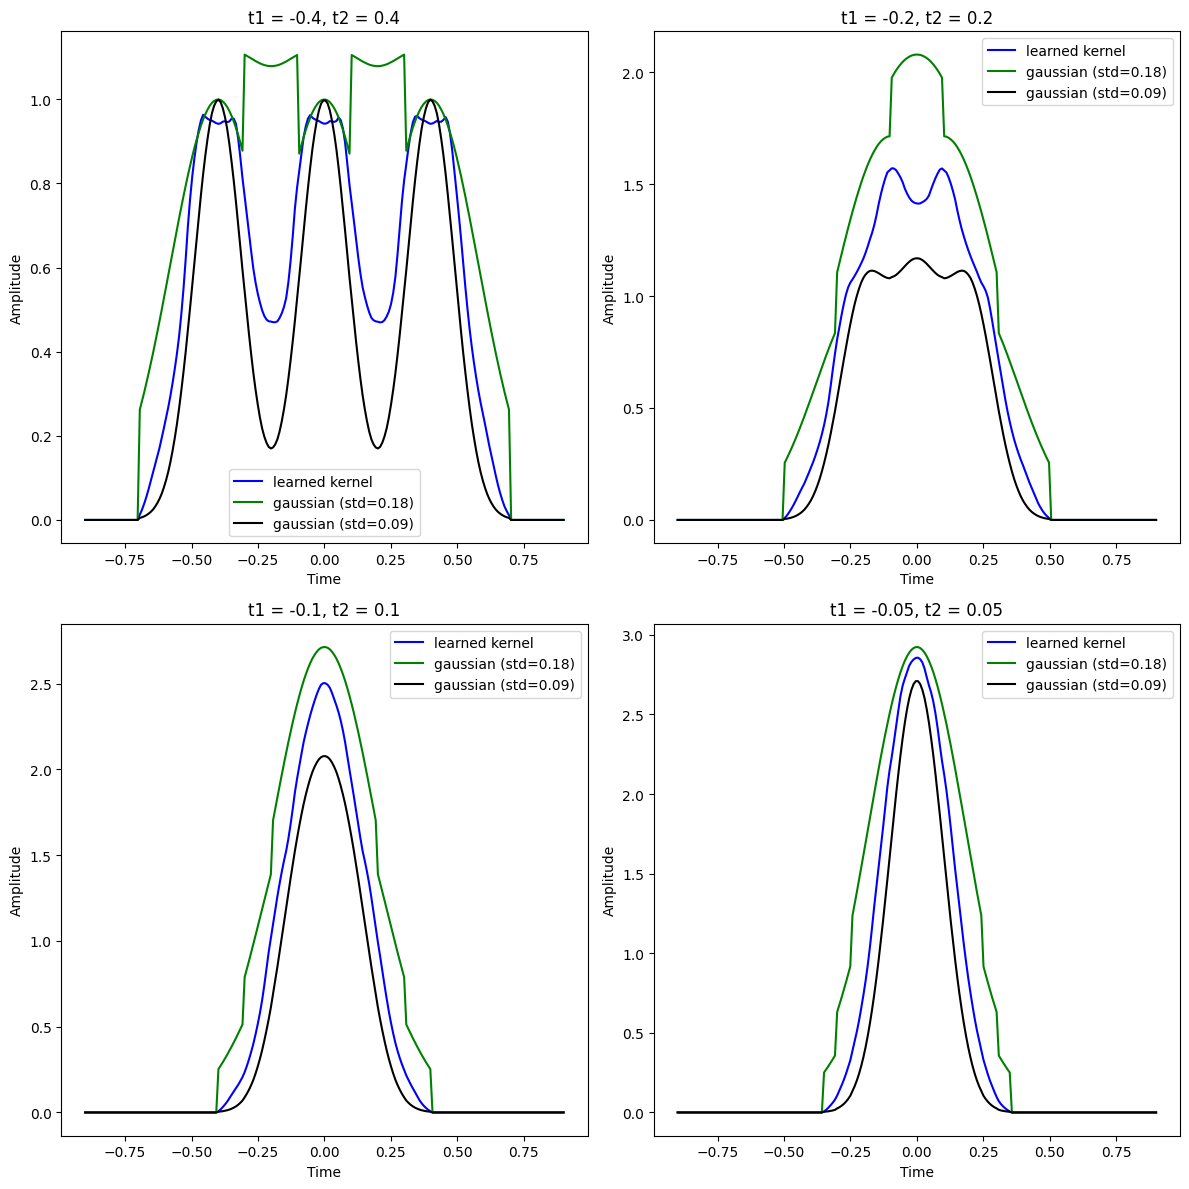

In [202]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

print(axes.shape)

axes[0, 0].plot(t_rng_disp.cpu().detach().numpy(), sig_disp1.cpu().detach().numpy()[0], label="learned kernel", color="b")
axes[0, 0].plot(t_rng_disp.cpu().detach().numpy(), sig_disp2.cpu().detach().numpy()[0], label="gaussian (std=0.18)", color="g")
axes[0, 0].plot(t_rng_disp.cpu().detach().numpy(), sig_disp3.cpu().detach().numpy()[0], label="gaussian (std=0.09)", color="k")
# axes[0, 0].plot(t_rng_disp.cpu().detach().numpy(), sig_disp4.cpu().detach().numpy()[0], label="gaussian pair", color="r")
axes[0, 0].set_xlabel("Time")
axes[0, 0].set_ylabel("Amplitude") 
axes[0, 0].legend()
axes[0, 0].set_title("t1 = -0.4, t2 = 0.4")

axes[0, 1].plot(t_rng_disp.cpu().detach().numpy(), sig_disp1.cpu().detach().numpy()[1], label="learned kernel", color="b")
axes[0, 1].plot(t_rng_disp.cpu().detach().numpy(), sig_disp2.cpu().detach().numpy()[1], label="gaussian (std=0.18)", color="g")
axes[0, 1].plot(t_rng_disp.cpu().detach().numpy(), sig_disp3.cpu().detach().numpy()[1], label="gaussian (std=0.09)", color="k")
# axes[0, 1].plot(t_rng_disp.cpu().detach().numpy(), sig_disp4.cpu().detach().numpy()[1], label="gaussian pair", color="r")
axes[0, 1].set_xlabel("Time")
axes[0, 1].set_ylabel("Amplitude")
axes[0, 1].legend()
axes[0, 1].set_title("t1 = -0.2, t2 = 0.2")

axes[1, 0].plot(t_rng_disp.cpu().detach().numpy(), sig_disp1.cpu().detach().numpy()[2], label="learned kernel", color="b")
axes[1, 0].plot(t_rng_disp.cpu().detach().numpy(), sig_disp2.cpu().detach().numpy()[2], label="gaussian (std=0.18)", color="g")
axes[1, 0].plot(t_rng_disp.cpu().detach().numpy(), sig_disp3.cpu().detach().numpy()[2], label="gaussian (std=0.09)", color="k")
# axes[1, 0].plot(t_rng_disp.cpu().detach().numpy(), sig_disp4.cpu().detach().numpy()[2], label="gaussian pair", color="r")
axes[1, 0].set_xlabel("Time")
axes[1, 0].set_ylabel("Amplitude")
axes[1, 0].legend()
axes[1, 0].set_title("t1 = -0.1, t2 = 0.1")

axes[1, 1].plot(t_rng_disp.cpu().detach().numpy(), sig_disp1.cpu().detach().numpy()[3], label="learned kernel", color="b")
axes[1, 1].plot(t_rng_disp.cpu().detach().numpy(), sig_disp2.cpu().detach().numpy()[3], label="gaussian (std=0.18)", color="g")
axes[1, 1].plot(t_rng_disp.cpu().detach().numpy(), sig_disp3.cpu().detach().numpy()[3], label="gaussian (std=0.09)", color="k")
# axes[1, 1].plot(t_rng_disp.cpu().detach().numpy(), sig_disp4.cpu().detach().numpy()[3], label="gaussian pair", color="r")
axes[1, 1].set_xlabel("Time")
axes[1, 1].set_ylabel("Amplitude")
axes[1, 1].legend()
axes[1, 1].set_title("t1 = -0.05, t2 = 0.05")

plt.tight_layout()
plt.savefig("signals_samples11_locs3_new.png")

In [203]:
sig_test, loc_test = get_batch(data_test, model, len(aks_plot), 0, t_rng, 0)
sig_test = add_noise(sig_test, snr_dB)
model.eval()
tks_pred = model(sig_test).squeeze(0).cpu().detach().numpy()
tks_pred = torch.tensor(np.array(tks_pred)).float().to(device)

In [204]:
for param in model.parameters():
    param.requires_grad = False

In [205]:
aks_pred = 10 * (1 * torch.randn_like(aks_plot) + 1) / 2
optimizer = optim.Adam([aks_pred], lr=0.05)
train = TensorDataset(tks_pred, sig_test)
train = DataLoader(train, batch_size=64, shuffle=False)

aks_test = aks_plot.cpu().detach().numpy()
tks_pred = tks_pred.cpu().detach().numpy()
tks_test = loc_test.cpu().detach().numpy()

In [206]:
def mse_fit(coeffs, dataloader, loss_fn, epochs=30):
    
    coeffs.requires_grad_(True)
    
    for i in range(epochs):
        total_loss = 0
        for idx, batch in enumerate(dataloader):
            locs, sig_true = batch
            locs, sig_true = locs.to(device), sig_true.to(device)
            
            start_idx = idx*locs.shape[0]
            end_idx = min((idx + 1)*locs.shape[0], coeffs.shape[0])
            
            amp_batch = coeffs[start_idx:end_idx, :]
            
            sig_pred = model.get_signal(amp_batch, locs, t_rng)
            loss = loss_fn(sig_pred, sig_true)
            optimizer.zero_grad()

            loss.backward(retain_graph=True)
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {i+1}/{epochs}, Loss: {total_loss/len(dataloader)}")
        
    coeffs.requires_grad_(False)
        
    return coeffs

In [207]:
aks_pred = mse_fit(aks_pred, train, F.mse_loss, epochs=300)
aks_pred = aks_pred.cpu().detach().numpy()

Epoch 1/300, Loss: 19.91897201538086
Epoch 2/300, Loss: 19.59861946105957
Epoch 3/300, Loss: 19.281579971313477
Epoch 4/300, Loss: 18.967906951904297
Epoch 5/300, Loss: 18.657655715942383
Epoch 6/300, Loss: 18.350873947143555
Epoch 7/300, Loss: 18.047607421875
Epoch 8/300, Loss: 17.747900009155273
Epoch 9/300, Loss: 17.45178985595703
Epoch 10/300, Loss: 17.159313201904297
Epoch 11/300, Loss: 16.870502471923828
Epoch 12/300, Loss: 16.58538246154785
Epoch 13/300, Loss: 16.303977966308594
Epoch 14/300, Loss: 16.02630615234375
Epoch 15/300, Loss: 15.75238037109375
Epoch 16/300, Loss: 15.48220443725586
Epoch 17/300, Loss: 15.215788841247559
Epoch 18/300, Loss: 14.953124046325684
Epoch 19/300, Loss: 14.694215774536133
Epoch 20/300, Loss: 14.439040184020996
Epoch 21/300, Loss: 14.187594413757324
Epoch 22/300, Loss: 13.939852714538574
Epoch 23/300, Loss: 13.695793151855469
Epoch 24/300, Loss: 13.455388069152832
Epoch 25/300, Loss: 13.218612670898438
Epoch 26/300, Loss: 12.985435485839844
Epoch

Epoch 63/300, Loss: 6.55730676651001
Epoch 64/300, Loss: 6.4341654777526855
Epoch 65/300, Loss: 6.313205718994141
Epoch 66/300, Loss: 6.194389343261719
Epoch 67/300, Loss: 6.077678680419922
Epoch 68/300, Loss: 5.963037014007568
Epoch 69/300, Loss: 5.850428104400635
Epoch 70/300, Loss: 5.739814758300781
Epoch 71/300, Loss: 5.631165981292725
Epoch 72/300, Loss: 5.524441242218018
Epoch 73/300, Loss: 5.419609069824219
Epoch 74/300, Loss: 5.316636562347412
Epoch 75/300, Loss: 5.215488433837891
Epoch 76/300, Loss: 5.116133213043213
Epoch 77/300, Loss: 5.0185394287109375
Epoch 78/300, Loss: 4.922674655914307
Epoch 79/300, Loss: 4.8285088539123535
Epoch 80/300, Loss: 4.736010551452637
Epoch 81/300, Loss: 4.645151615142822
Epoch 82/300, Loss: 4.555902004241943
Epoch 83/300, Loss: 4.468235015869141
Epoch 84/300, Loss: 4.382120132446289
Epoch 85/300, Loss: 4.297532081604004
Epoch 86/300, Loss: 4.214443683624268
Epoch 87/300, Loss: 4.1328277587890625
Epoch 88/300, Loss: 4.052659511566162
Epoch 89/

In [208]:
idx = np.random.randint(0, len(aks_test))
print(aks_test[idx])
print(aks_pred[idx])

tks_mse = []
aks_mse = []

for i in range(len(aks_plot)):
    tks_mse.append(mse_db(tks_pred[i], tks_test[i]))
    aks_mse.append(mse_db(aks_pred[i], aks_test[i]))
    
print("Location prediction MSE (dB) :", np.mean(tks_mse))
print("Amplitude prediction MSE (dB) :", np.mean(aks_mse))

[1. 1. 1.]
[-0.8194477  3.1348798  1.355751 ]
Location prediction MSE (dB) : -29.42755401134491
Amplitude prediction MSE (dB) : -7.566169686615467


In [209]:
tks_mse

[-56.760311126708984,
 -30.217630863189697,
 -18.301024436950684,
 -12.431249618530273]

In [210]:
aks_mse

[-30.77925205230713, -5.846733450889587, 4.256787896156311, 2.104518860578537]